In [217]:
from collections import defaultdict
from functools import lru_cache
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image, ImageFilter, ImageEnhance
import numpy as np
import os
import random

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [218]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [219]:
# Define the MLP model that takes the difference between two embeddings
class FaceVerificationMLP(nn.Module):
    def __init__(self, input_dim=512):
        super(FaceVerificationMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output: [same_person_prob, different_person_prob]
        )

    def forward(self, x):
        return self.model(x)

In [220]:
class FaceVerificationSystem:
    def __init__(self):
        pass

    # Function to compare two images and get the absolute difference vector
    def get_diff_vector(self, emb1, emb2):
        return torch.abs(emb1 - emb2)

    def train_model(self, train_data, lr=0.001, epochs=20, lr_scheduler=False, early_stopping=False, patience=5):
        # Prepare training tensors
        X_train = []
        y_train = []
        for emb1, emb2, label in train_data:
            diff = self.get_diff_vector(emb1, emb2)
            X_train.append(diff.squeeze(0))
            y_train.append(label)

        X_train = torch.stack(X_train)
        y_train = torch.tensor(y_train)

        # Define model, loss, optimizer (note: this is an example, adjust it according to the task)
        model = FaceVerificationMLP()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = None

        if lr_scheduler:
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

        best_loss = float('inf')
        epochs_no_improve = 0

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step(loss)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

            if early_stopping:
                if loss.item() < best_loss - 1e-4:  # small tolerance to avoid floating point issues
                    best_loss = loss.item()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break

        return model

    def predict_same_person(self, emb1, emb2, model):
        model.eval()
        diff = self.get_diff_vector(emb1, emb2)
        output = model(diff)
        _, predicted = torch.max(output, 1)
        return 1 if predicted.item() == 1 else 0


In [221]:
class ImageDataLoader:
    def __init__(self):
        self.mtcnn = MTCNN(image_size=160, margin=20)
        self.facenet = InceptionResnetV1(pretrained='vggface2').eval()

        self.EMBEDDING_CACHE_PATH = 'data/embeddings.pth'
        self.embeddings_cache = {}

        self.precompute_embeddings()

    def get_image(self, img_path):
        return Image.open(img_path).convert('RGB')

    def get_embedding_from_img_path(self, image_path):
        img_name = image_path.split('/')[-1]
        embedding = self.embeddings_cache.get(img_name)
        if not(embedding is None):
            return embedding
        image = self.get_image(image_path)
        return self.get_embedding_from_img(image)

    def get_embedding_from_img(self, image):
        face = self.mtcnn(image)  # returns a cropped, aligned face
        if face is None:
            raise FaceNotFoundException()
        face_embedding = self.facenet(face.unsqueeze(0))  # Add batch dimension
        return face_embedding.detach()

    def precompute_embeddings(self):
        if os.path.exists(self.EMBEDDING_CACHE_PATH):
            print("Loading embeddings from cache...")
            self.embeddings_cache = torch.load(self.EMBEDDING_CACHE_PATH)
            return

        print("Precomputing embeddings...")
        celeba_path = 'data/img_align_celeba'
        img_files = [os.path.join(celeba_path, p) for p in os.listdir(celeba_path)]

        for img_file in tqdm(img_files):
            img_name = os.path.basename(img_file)
            try:
                embedding = self.get_embedding_from_img_path(img_file)
            except FaceNotFoundException:
                continue
            self.embeddings_cache[img_name] = embedding

        torch.save(self.embeddings_cache, self.EMBEDDING_CACHE_PATH)

    def get_train_test_subset(self, n_train=1000, train_paired_ratio=0.5, n_test=200, test_paired_ratio=0.5):
        n_train_paired = int(n_train * train_paired_ratio)
        n_train_unpaired = n_train - n_train_paired
        n_test_paired = int(n_test * test_paired_ratio)
        n_test_unpaired = n_test - n_test_paired

        train_paired_data = []
        train_unpaired_data = []
        test_paired_data = []
        test_unpaired_data = []
        test_set = set()
        images_path = 'data/img_align_celeba'

        with open('data/Anno/identity_CelebA.txt', 'r') as file:
            identity_dict = defaultdict(list)
            file_identity_list = []
            for file_identity in file:
                try:
                    file, identity = file_identity.split()
                    file = os.path.join(images_path, file)
                    identity = int(identity)
                    identity_dict[identity].append(file)
                    file_identity_list.append((file, identity))
                except ValueError as err:
                    print(f"Error occurred in line {file_identity}: {err}")
            identities = list(identity_dict.keys())

            while len(train_paired_data) < n_train_paired:
                id = np.random.choice(identities)
                while len(identity_dict[id]) < 2:
                    id = np.random.choice(identities)
                img_pair = np.random.choice(identity_dict[id], size=2, replace=False)
                train_paired_data.append((*img_pair, 1))
                test_set.add(id)

            while len(train_unpaired_data) < n_train_unpaired:
                ids = np.random.choice(identities, size=2, replace=False)
                img_pair = np.random.choice(identity_dict[ids[0]]), np.random.choice(identity_dict[ids[1]])
                train_unpaired_data.append((*img_pair, 0))
                test_set.add(ids[0])
                test_set.add(ids[1])

            test_identities = [id for id in identities if id not in test_set]
            while len(test_paired_data) < n_test_paired:
                id = np.random.choice(test_identities)
                while len(identity_dict[id]) < 2:
                    id = np.random.choice(test_identities)
                img_pair = np.random.choice(identity_dict[id], size=2, replace=False)
                test_paired_data.append((*img_pair, 1))

            while len(test_unpaired_data) < n_test_unpaired:
                ids = np.random.choice(test_identities, size=2, replace=False)
                img_pair = np.random.choice(identity_dict[ids[0]]), np.random.choice(identity_dict[ids[1]])
                test_unpaired_data.append((*img_pair, 0))

            train_data = train_paired_data + train_unpaired_data
            test_data = test_paired_data + test_unpaired_data
            np.random.shuffle(train_data)
            np.random.shuffle(test_data)

            return train_data, test_data

    def img_pair_list_to_embedding_pair_list(self, l):
        e_l = []
        for i in l:
            try:
                emb1 = self.get_embedding_from_img_path(i[0])
                emb2 = self.get_embedding_from_img_path(i[1])
            except FaceNotFoundException:
                continue
            e_l.append((emb1, emb2, i[2]))
        return e_l


In [222]:
class FaceNotFoundException(Exception):
    pass

In [223]:
def augment_image(image, augment_type="gaussian_noise"):
    if augment_type == "gaussian_noise":
        # Add Gaussian noise
        image_np = np.array(image).astype(np.float32)
        # Modify the parameter value to adjust noise level if needed
        noise = np.random.normal(0, 25, image_np.shape)
        noisy_image = image_np + noise
        noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
        augmented = Image.fromarray(noisy_image)
    elif augment_type == "blur":
        # Apply Gaussian blur with radius 3
        augmented = image.filter(ImageFilter.GaussianBlur(radius=3))
    elif augment_type == "increased_lighting":
        # Increase brightness by 50%
        enhancer = ImageEnhance.Brightness(image)
        augmented = enhancer.enhance(1.5)
    else:
        augmented = image
    return augmented

In [224]:
facialVerificationSystem = FaceVerificationSystem()
imageLoader = ImageDataLoader()

Loading embeddings from cache...


# Zadanie 1.

In [225]:
n_test = 200
test_paired_ratio = 0.5
train_paired_ratio = 0.5

scores = {
    10: None,
    100: None,
    500: None,
    1000: None,
    5000: None
}

for n_train in scores:
    print(f"Training for {n_train} image pairs")

    train_data, test_data = imageLoader.get_train_test_subset(n_train, train_paired_ratio, n_test, test_paired_ratio)

    train_data = imageLoader.img_pair_list_to_embedding_pair_list(train_data)
    test_data = imageLoader.img_pair_list_to_embedding_pair_list(test_data)

    model = facialVerificationSystem.train_model(train_data)

    print(f"Training completed.\nPredicting...")

    predicted_data = []
    for d in test_data:
        predicted_data.append((d[0], d[1], facialVerificationSystem.predict_same_person(d[0], d[1], model)))

    print("Prediction completed.\n")

    Y_test = [x[2] for x in test_data]
    Y_predict = [y[2] for y in predicted_data]

    cm = confusion_matrix(Y_test, Y_predict)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(Y_test, Y_predict)
    recall = recall_score(Y_test, Y_predict, zero_division=0)
    precision = precision_score(Y_test, Y_predict, zero_division=0)
    f1 = f1_score(Y_test, Y_predict, zero_division=0)

    metrics = {
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }
    scores[n_train] = metrics

    print(f"Results for {n_train} image pairs:")
    #print(f"Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}")
    for k, v in metrics.items():
        print(f"{k}: {v}")

Training for 10 image pairs
Epoch 1/20, Loss: 0.6939
Epoch 2/20, Loss: 0.6843
Epoch 3/20, Loss: 0.6763
Epoch 4/20, Loss: 0.6681
Epoch 5/20, Loss: 0.6595
Epoch 6/20, Loss: 0.6501
Epoch 7/20, Loss: 0.6395
Epoch 8/20, Loss: 0.6277
Epoch 9/20, Loss: 0.6149
Epoch 10/20, Loss: 0.6009
Epoch 11/20, Loss: 0.5857
Epoch 12/20, Loss: 0.5694
Epoch 13/20, Loss: 0.5522
Epoch 14/20, Loss: 0.5340
Epoch 15/20, Loss: 0.5148
Epoch 16/20, Loss: 0.4946
Epoch 17/20, Loss: 0.4736
Epoch 18/20, Loss: 0.4517
Epoch 19/20, Loss: 0.4289
Epoch 20/20, Loss: 0.4052
Training completed.
Predicting...
Prediction completed.

Results for 10 image pairs:
confusion_matrix: [[100   0]
 [ 88  12]]
accuracy: 0.56
recall: 0.12
precision: 1.0
f1: 0.21428571428571427
tp: 12
tn: 100
fp: 0
fn: 88
Training for 100 image pairs
Epoch 1/20, Loss: 0.6933
Epoch 2/20, Loss: 0.6873
Epoch 3/20, Loss: 0.6832
Epoch 4/20, Loss: 0.6791
Epoch 5/20, Loss: 0.6747
Epoch 6/20, Loss: 0.6698
Epoch 7/20, Loss: 0.6649
Epoch 8/20, Loss: 0.6592
Epoch 9/20,

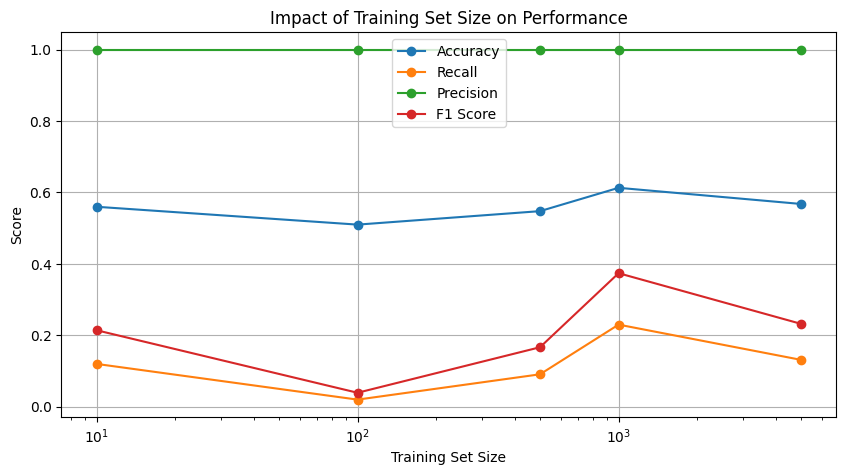

In [226]:
def plot_model_performance(scores, x_label, log=False):
    accuracies = [scores[s]['accuracy'] for s in scores]
    recalls = [scores[s]['recall'] for s in scores]
    precisions = [scores[s]['precision'] for s in scores]
    f1_scores = [scores[s]['f1'] for s in scores]

    plt.figure(figsize=(10, 5))
    plt.plot(list(scores.keys()), accuracies, 'o-', label='Accuracy')
    plt.plot(list(scores.keys()), recalls, 'o-', label='Recall')
    plt.plot(list(scores.keys()), precisions, 'o-', label='Precision')
    plt.plot(list(scores.keys()), f1_scores, 'o-', label='F1 Score')
    if log:
        plt.xscale('log')
    plt.xlabel(x_label)
    plt.ylabel('Score')
    plt.title('Impact of Training Set Size on Performance')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_model_performance(scores, x_label='Training Set Size', log=True)

# Zadanie 2.

In [227]:
n_train = 1000
n_test = 200
test_paired_ratio = 0.5
train_paired_ratio = 0.5

scores = {
    0.0001: None,
    0.0005: None,
    0.001: None,
    0.005: None,
    0.01: None
}

train_data, test_data = imageLoader.get_train_test_subset(n_train, train_paired_ratio, n_test, test_paired_ratio)

train_data = imageLoader.img_pair_list_to_embedding_pair_list(train_data)
test_data = imageLoader.img_pair_list_to_embedding_pair_list(test_data)

for lr in scores:
    print(f"Training for {lr} learning rate")

    model = facialVerificationSystem.train_model(train_data, lr=lr)

    print(f"Training completed.\nPredicting...")

    predicted_data = []
    for d in test_data:
        predicted_data.append((d[0], d[1], facialVerificationSystem.predict_same_person(d[0], d[1], model)))

    print("Prediction completed.\n")

    Y_test = [x[2] for x in test_data]
    Y_predict = [y[2] for y in predicted_data]

    cm = confusion_matrix(Y_test, Y_predict)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(Y_test, Y_predict)
    recall = recall_score(Y_test, Y_predict, zero_division=0)
    precision = precision_score(Y_test, Y_predict, zero_division=0)
    f1 = f1_score(Y_test, Y_predict, zero_division=0)

    metrics = {
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }
    scores[lr] = metrics

    print(f"Results for {lr} learning rate:")
    for k, v in metrics.items():
        print(f"{k}: {v}")

Training for 0.0001 learning rate
Epoch 1/20, Loss: 0.6928
Epoch 2/20, Loss: 0.6919
Epoch 3/20, Loss: 0.6911
Epoch 4/20, Loss: 0.6902
Epoch 5/20, Loss: 0.6893
Epoch 6/20, Loss: 0.6885
Epoch 7/20, Loss: 0.6876
Epoch 8/20, Loss: 0.6867
Epoch 9/20, Loss: 0.6858
Epoch 10/20, Loss: 0.6850
Epoch 11/20, Loss: 0.6841
Epoch 12/20, Loss: 0.6832
Epoch 13/20, Loss: 0.6823
Epoch 14/20, Loss: 0.6813
Epoch 15/20, Loss: 0.6804
Epoch 16/20, Loss: 0.6794
Epoch 17/20, Loss: 0.6785
Epoch 18/20, Loss: 0.6775
Epoch 19/20, Loss: 0.6765
Epoch 20/20, Loss: 0.6754
Training completed.
Predicting...
Prediction completed.

Results for 0.0001 learning rate:
confusion_matrix: [[99  0]
 [70 30]]
accuracy: 0.6482412060301508
recall: 0.3
precision: 1.0
f1: 0.46153846153846156
tp: 30
tn: 99
fp: 0
fn: 70
Training for 0.0005 learning rate
Epoch 1/20, Loss: 0.6937
Epoch 2/20, Loss: 0.6897
Epoch 3/20, Loss: 0.6862
Epoch 4/20, Loss: 0.6827
Epoch 5/20, Loss: 0.6789
Epoch 6/20, Loss: 0.6749
Epoch 7/20, Loss: 0.6708
Epoch 8/20,

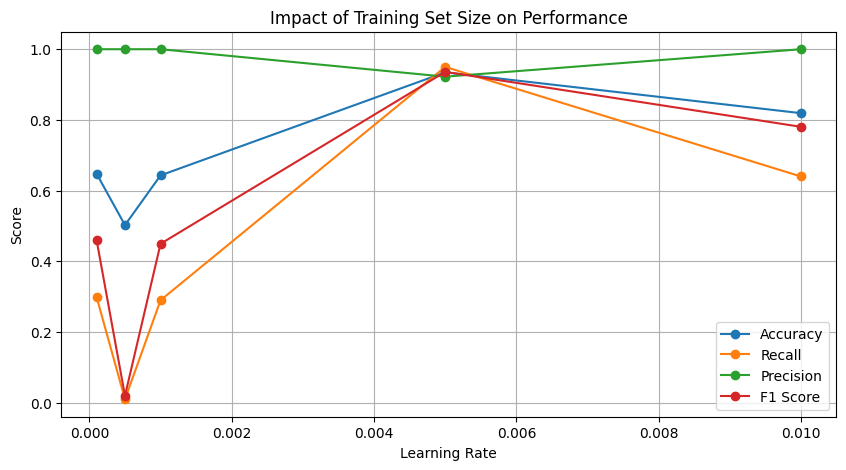

In [228]:
plot_model_performance(scores, x_label='Learning Rate')

# Zadanie 3.

In [229]:
n_train = 1000
n_test = 200
test_paired_ratio = 0.5
train_paired_ratio = 0.5

scores = {
    5: None,
    10: None,
    20: None,
    40: None,
    80: None
}

train_data, test_data = imageLoader.get_train_test_subset(n_train, train_paired_ratio, n_test, test_paired_ratio)

train_data = imageLoader.img_pair_list_to_embedding_pair_list(train_data)
test_data = imageLoader.img_pair_list_to_embedding_pair_list(test_data)

for epochs in scores:
    print(f"Training for {epochs} Epochs")

    model = facialVerificationSystem.train_model(train_data, epochs=epochs)

    print(f"Training completed.\nPredicting...")

    predicted_data = []
    for d in test_data:
        predicted_data.append((d[0], d[1], facialVerificationSystem.predict_same_person(d[0], d[1], model)))

    print("Prediction completed.\n")

    Y_test = [x[2] for x in test_data]
    Y_predict = [y[2] for y in predicted_data]

    cm = confusion_matrix(Y_test, Y_predict)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(Y_test, Y_predict)
    recall = recall_score(Y_test, Y_predict, zero_division=0)
    precision = precision_score(Y_test, Y_predict, zero_division=0)
    f1 = f1_score(Y_test, Y_predict, zero_division=0)

    metrics = {
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }
    scores[epochs] = metrics

    print(f"Results for {epochs} Epochs:")
    for k, v in metrics.items():
        print(f"{k}: {v}")

Training for 5 Epochs
Epoch 1/5, Loss: 0.6940
Epoch 2/5, Loss: 0.6897
Epoch 3/5, Loss: 0.6854
Epoch 4/5, Loss: 0.6814
Epoch 5/5, Loss: 0.6772
Training completed.
Predicting...
Prediction completed.

Results for 5 Epochs:
confusion_matrix: [[100   0]
 [100   0]]
accuracy: 0.5
recall: 0.0
precision: 0.0
f1: 0.0
tp: 0
tn: 100
fp: 0
fn: 100
Training for 10 Epochs
Epoch 1/10, Loss: 0.6933
Epoch 2/10, Loss: 0.6883
Epoch 3/10, Loss: 0.6831
Epoch 4/10, Loss: 0.6772
Epoch 5/10, Loss: 0.6709
Epoch 6/10, Loss: 0.6648
Epoch 7/10, Loss: 0.6587
Epoch 8/10, Loss: 0.6533
Epoch 9/10, Loss: 0.6491
Epoch 10/10, Loss: 0.6459
Training completed.
Predicting...
Prediction completed.

Results for 10 Epochs:
confusion_matrix: [[100   0]
 [100   0]]
accuracy: 0.5
recall: 0.0
precision: 0.0
f1: 0.0
tp: 0
tn: 100
fp: 0
fn: 100
Training for 20 Epochs
Epoch 1/20, Loss: 0.6941
Epoch 2/20, Loss: 0.6876
Epoch 3/20, Loss: 0.6826
Epoch 4/20, Loss: 0.6775
Epoch 5/20, Loss: 0.6713
Epoch 6/20, Loss: 0.6651
Epoch 7/20, Loss

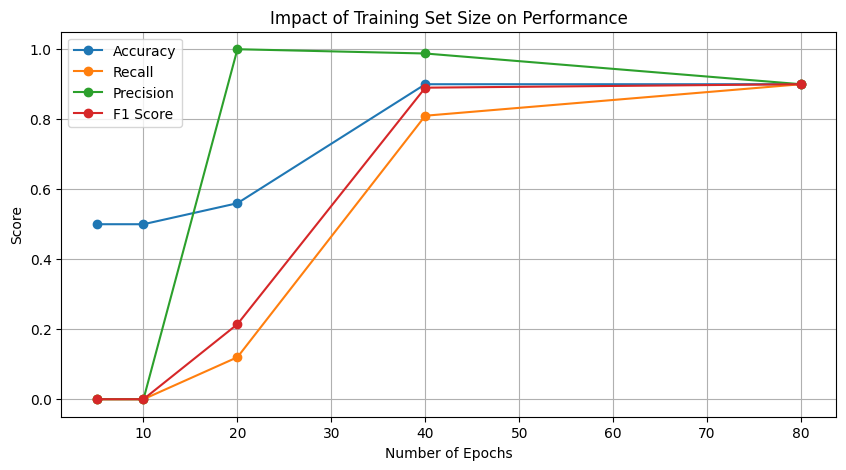

In [230]:
plot_model_performance(scores, x_label='Number of Epochs')

# Zadanie 4.

zaimplementowany adaptive lr scheduler i early stopping - trzeba tylko dobrac najlepsze parametry na podstawie poprzednich podpunktow i pusicic

size = 1000

lr = 0.005

epochs = 80 (jak za wolno to 40 tez git)

In [235]:
n_train = 1000
n_test = 200
train_paired_ratio = 0.5
test_paired_ratio = 0.5

lr = 0.005

epochs = 80 # 40

train_data, test_data = imageLoader.get_train_test_subset(n_train, train_paired_ratio, n_test, test_paired_ratio)

train_data = imageLoader.img_pair_list_to_embedding_pair_list(train_data)
test_data = imageLoader.img_pair_list_to_embedding_pair_list(test_data)

model = facialVerificationSystem.train_model(
    train_data,
    lr=lr,
    epochs=epochs,
    lr_scheduler = True,
    early_stopping = True,
    patience = 5
)

print(f"Training completed.\nPredicting...")

predicted_data = []
for d in test_data:
    predicted_data.append((d[0], d[1], facialVerificationSystem.predict_same_person(d[0], d[1], model)))

print("Prediction completed.\n")

Y_test = [x[2] for x in test_data]
Y_predict = [y[2] for y in predicted_data]

cm = confusion_matrix(Y_test, Y_predict)
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(Y_test, Y_predict)
recall = recall_score(Y_test, Y_predict, zero_division=0)
precision = precision_score(Y_test, Y_predict, zero_division=0)
f1 = f1_score(Y_test, Y_predict, zero_division=0)

metrics = {
    "confusion_matrix": cm,
    "accuracy": accuracy,
    "recall": recall,
    "precision": precision,
    "f1": f1,
    "tp": tp,
    "tn": tn,
    "fp": fp,
    "fn": fn
}

print(f"Results:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Epoch 1/80, Loss: 0.6992
Epoch 2/80, Loss: 0.6570
Epoch 3/80, Loss: 0.6336
Epoch 4/80, Loss: 0.6444
Epoch 5/80, Loss: 0.6261
Epoch 6/80, Loss: 0.6208
Epoch 7/80, Loss: 0.6217
Epoch 8/80, Loss: 0.6153
Epoch 9/80, Loss: 0.6040
Epoch 10/80, Loss: 0.5960
Epoch 11/80, Loss: 0.5914
Epoch 12/80, Loss: 0.5825
Epoch 13/80, Loss: 0.5688
Epoch 14/80, Loss: 0.5585
Epoch 15/80, Loss: 0.5477
Epoch 16/80, Loss: 0.5284
Epoch 17/80, Loss: 0.5136
Epoch 18/80, Loss: 0.4931
Epoch 19/80, Loss: 0.4704
Epoch 20/80, Loss: 0.4473
Epoch 21/80, Loss: 0.4196
Epoch 22/80, Loss: 0.3912
Epoch 23/80, Loss: 0.3684
Epoch 24/80, Loss: 0.3358
Epoch 25/80, Loss: 0.3070
Epoch 26/80, Loss: 0.2857
Epoch 27/80, Loss: 0.2584
Epoch 28/80, Loss: 0.2251
Epoch 29/80, Loss: 0.2075
Epoch 30/80, Loss: 0.1914
Epoch 31/80, Loss: 0.1576
Epoch 32/80, Loss: 0.1476
Epoch 33/80, Loss: 0.1412
Epoch 34/80, Loss: 0.1103
Epoch 35/80, Loss: 0.1185
Epoch 36/80, Loss: 0.1105
Epoch 37/80, Loss: 0.0890
Epoch 38/80, Loss: 0.1044
Epoch 39/80, Loss: 0.

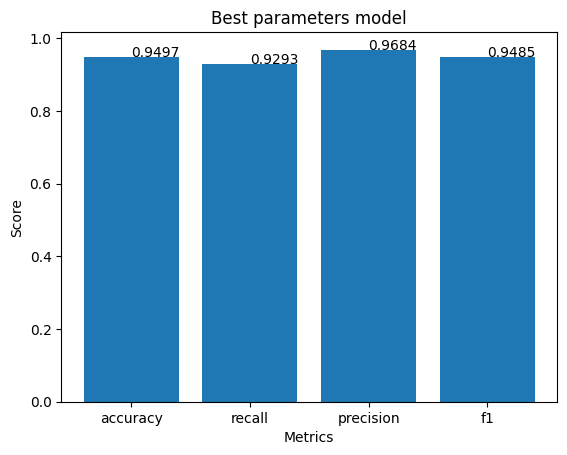

In [239]:
x = ['accuracy', 'recall', 'precision', 'f1']
y = [metrics[k] for k in x]

plt.bar(x, y)
plt.title('Best parameters model')
plt.xlabel('Metrics')
plt.ylabel('Score')
for index, value in enumerate(y):
    plt.text(index, value, str(round(value, 4)))
plt.show()

# Zadanie 5.

In [ ]:
# TODO